In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem


Generate a dataframe of SMC dft dataset

In [65]:
#Preparing to match dft data to ligands we use in smc
#Turing smiles from smc to inchi
df = pd.read_excel('P_selected.xlsx', engine = 'openpyxl', sheet_name='manual_vs_cmcl_UMAP')
#smc_inchi = smc_df['Smiles'].map(Chem.MolFromSmiles).map(Chem.MolToInchi)

In [66]:
df.shape

(247, 204)

Clean up the data
 - clear up non values
 - dropping zero-variance features and similar features

In [67]:
#Arbitrarily assign 0 value to all NaN spaces
df.replace(np.nan, 0)
df = df.sample(frac=1,random_state=42)
#Dropping some of the incomplete/useless parts of dataset
df_origin = df
df_y=df[['ID','x198']]
try:
    df = df.drop(columns = ['SMILES','y1','y2','y3','y4','buch'])
    df = df.drop(columns = ['y6','y10','y11','y12','y13','y14','y17'])
    df = df.drop(columns = ['y15','y16','y18','y19','y5','y7','y8','y9'])
    df = df.drop(columns = ['y1','y2','y11','y12','y13','y14','y16','SMILES','x198'])
except:
    pass
df.to_excel("output.xlsx")  


In [68]:
df=df.drop(columns = ['SMILES','SMC_dataset','x198'])

In [69]:
# drop highly correlated features
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(to_drop, axis=1)
print (f"Dropping {len(to_drop)} features {to_drop}")

Dropping 57 features ['ID', 'x7', 'x11', 'x22', 'x33', 'x39', 'x40', 'x41', 'x48', 'x49', 'x63', 'x71', 'x72', 'x73', 'x74', 'x75', 'x81', 'x82', 'x83', 'x84', 'x85', 'Unnamed: 110', 'x89', 'x90', 'x94', 'x96', 'x99', 'x100', 'x102', 'x107', 'x108', 'x110', 'x111', 'x113', 'x114', 'x119', 'x124', 'x127', 'x130', 'x134', 'x135', 'x136', 'x137', 'x138', 'x140', 'x142', 'x145', 'x148', 'x149', 'x150', 'x151', 'x152', 'x153', 'x155', 'x158', 'x159', 'x192']


c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
df = df.dropna()

UMAP Dimension Reduction to 2

In [71]:
from sklearn.decomposition import PCA
from umap import UMAP
# define the dimensionalities of the reduced representation to study
dims = [50, 30, 20, 10, 5, 2]
# dictionary to store data at different levels of dimensionality reduction
dfs={}
# UMAP section
n_neighbors = np.int(np.sqrt(df.shape[1]))
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors).fit_transform(df), index=df.index)
# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(df), index=df.index)
for dim in dims:
    key = f"pc{dim}"
    dfs[key] = pc.iloc[:, :dim]

c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


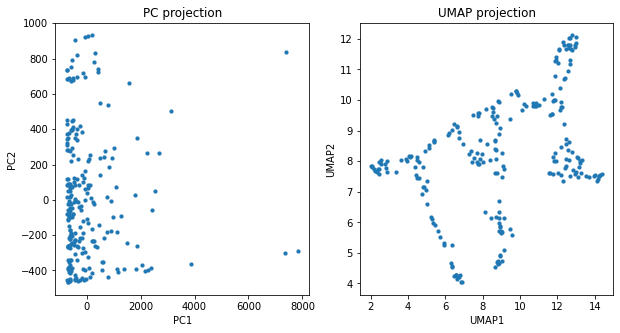

In [72]:
# Visualize the embeddings
f, ax = plt.subplots(1, 2, figsize=(10, 5)) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2']
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
_= sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=15, alpha=1, linewidth=0.25,  edgecolor='face', ax=ax[0]).set_title("PC projection")
_=sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=15, alpha=1, linewidth=0.25, edgecolor='face', ax=ax[1]).set_title("UMAP projection")

Clustering

In [73]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from sklearn.metrics import silhouette_score
# Define the numbeor of clusters to study
N_CLS_list = list(range(5, 41))
def silhouette_scores_hierarchical(data, n_cls_list):
 """helper function to compute a silhouette score for hierarchical cluster
ing using Ward linkage"""
 
 z = linkage(data, method='ward')
 
 result = pd.Series(index=n_cls_list, dtype=float)
 for n_cls in n_cls_list:
    cls = fcluster(z, n_cls, criterion='maxclust')
    result.loc[n_cls] = silhouette_score(data, cls)
 return result


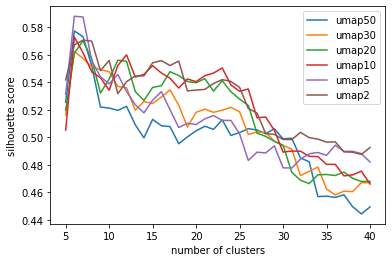

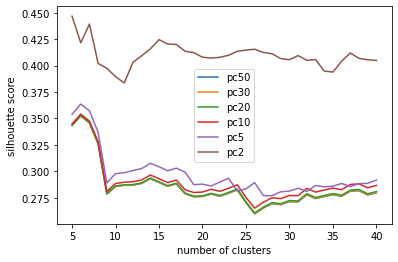

In [74]:
# populate silhouette scores for all number of clusters and all dimensionality reductions that are pre-calculated
silh_scores = pd.DataFrame(index=N_CLS_list)
for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)
# plot the silhouette scores
_=silh_scores.groupby(silh_scores.columns.str.startswith('pc'), axis=1).plot(
xlabel='number of clusters',ylabel='silhouette score')


Final Clustering

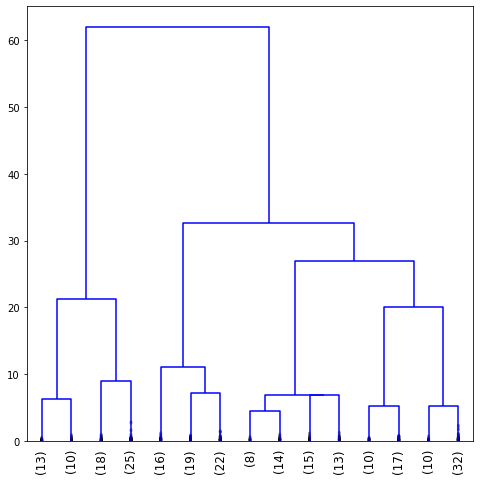

In [75]:
# final number of clusters to produce
NCLS = 15
# linkage and clustering for selected featurization
z = linkage(dfs['umap10'], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')
# plot the dendrogram
plt.figure(figsize=(8, 8))
_=dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True, leaf_rotation=90, color_threshold=0)


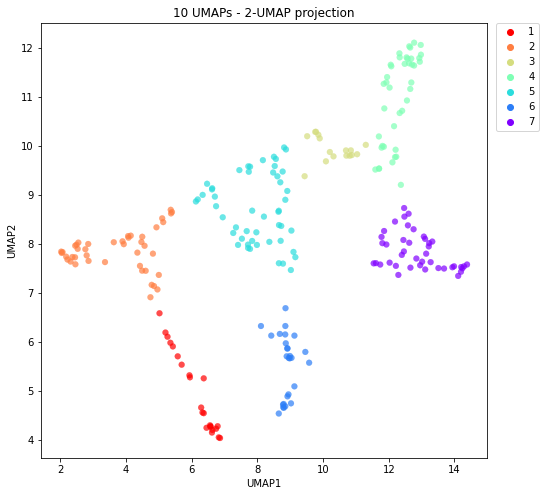

In [76]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
 palette='rainbow_r', legend='full', hue=cls).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)


In [77]:
df['SMC_dataset']=df_origin['SMC_dataset']

In [78]:
df

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x8,x9,x10,...,x189,x190,x191,x193,x199,x200,x201,x202,avai,SMC_dataset
33,71,-0.057294,1.820507,-0.236306,-0.024862,-0.130584,0.211444,0.086016,-0.414627,0.748238,...,0.591425,6.759989,8,73.927583,0,0,0,0,1,10
6,4,-0.062157,1.826696,-0.230615,0.036188,-0.097214,0.266803,0.128595,-0.495213,0.732884,...,1.038208,6.744437,7,20.388139,4,1,38,22,1,8
181,203,-0.041464,1.893024,-0.235070,-0.046860,-0.140965,0.188210,0.048030,-0.381450,0.792660,...,0.000000,7.083522,1,31.557194,0,0,0,0,0,0
86,346,-0.066191,1.796376,-0.218787,-0.009561,-0.114174,0.209226,0.077452,-0.347149,0.777506,...,2.164701,7.449083,39,3106.406611,0,0,0,0,0,4
155,751,-0.057534,1.820573,-0.230409,-0.017340,-0.123874,0.213069,0.092033,-0.416937,0.762843,...,0.512684,6.675518,2,7.008833,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,406,-0.056680,1.822420,-0.232021,-0.025227,-0.128624,0.206794,0.082416,-0.417273,0.721012,...,0.167696,6.765288,4,78.375972,0,0,0,0,0,4
14,39,-0.056110,1.784801,-0.228666,0.032498,-0.098084,0.261164,0.113030,-0.459615,0.740428,...,2.076087,7.639953,25,273.510250,12,27,37,0,1,8
92,595,-0.045365,1.811667,-0.224184,0.020766,-0.101709,0.244950,0.106918,-0.377112,1.304347,...,0.289083,6.735489,17,551.537417,0,0,0,0,0,4
179,557,-0.036499,1.881993,-0.224110,-0.039990,-0.132050,0.184120,0.055280,-0.383250,0.996870,...,0.000000,7.027403,1,55.619722,0,0,0,0,0,0


It makes sense - in cluster 2 there's full of phosphites. I won't expect them to be in the set of 'working ligands'. 

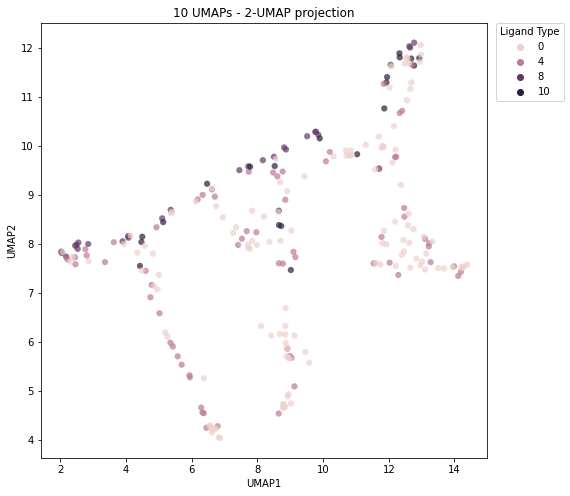

In [79]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
  legend='full', hue=df_origin['SMC_dataset']).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(title='Ligand Type',bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
#labels=['Probably not','Screened Aromatic', 'Screened Alkyl','Maybe','Priority']


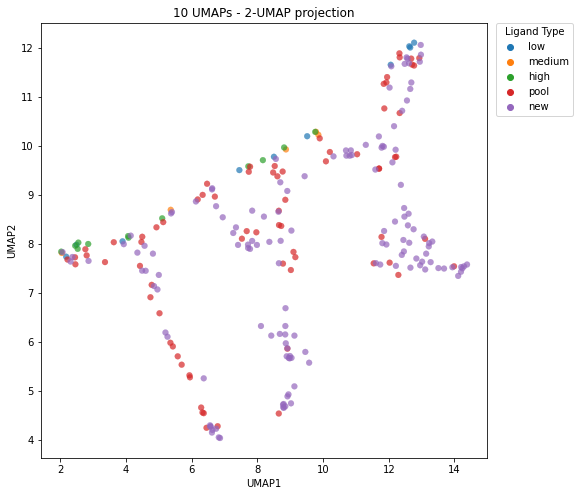

In [80]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
  legend='full', hue=df_origin['x198']).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(title='Ligand Type',bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
#labels=['Probably not','Screened Aromatic', 'Screened Alkyl','Maybe','Priority']

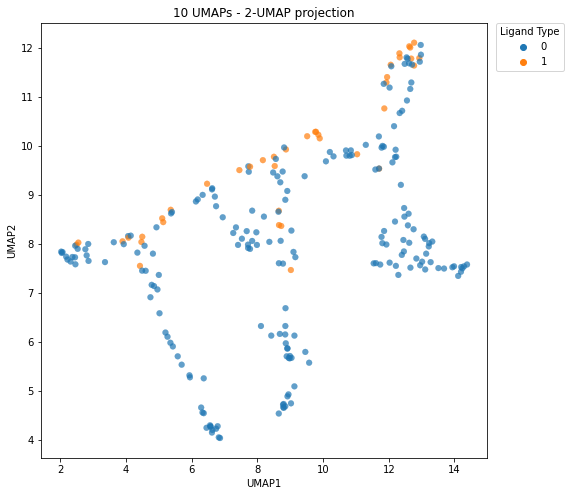

In [81]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=35, alpha=0.7, linewidth=0.25, edgecolor='face',
  legend='full', hue=df_origin['avai']).set_title("10 UMAPs - 2-UMAP projection")
_=plt.legend(title='Ligand Type',bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
#labels=['Probably not','Screened Aromatic', 'Screened Alkyl','Maybe','Priority']


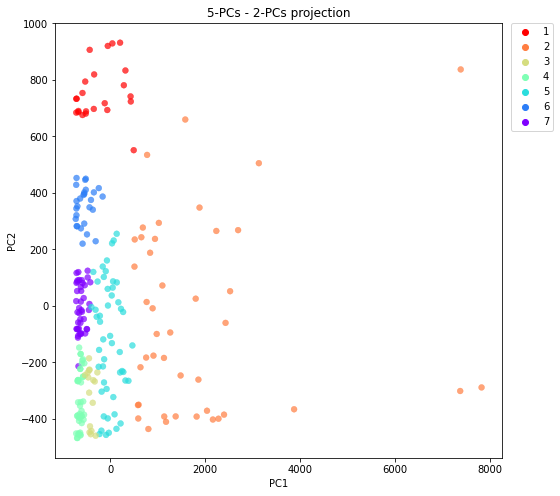

In [82]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="PC1", y="PC2", data=dfs['pc2'], s=35, alpha=0.7, linewidth=0.4, edgecolor='face',
 palette='rainbow_r', legend='full', hue=cls).set_title("5-PCs - 2-PCs projection")
_=plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

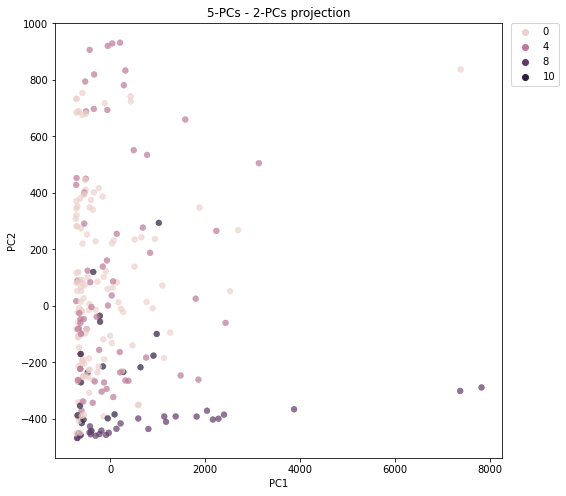

In [83]:
# plot clustering
NCLS = 7
cls = fcluster(z, NCLS, criterion='maxclust')
plt.figure(figsize=(8, 8))
sns.scatterplot(x="PC1", y="PC2", data=dfs['pc2'], s=35, alpha=0.7, linewidth=0.4, edgecolor='face',
 legend='full', hue=df['SMC_dataset']).set_title("5-PCs - 2-PCs projection")
_=plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

In [84]:
def generate_ligand_data(df):
    #Convert the smiles of ligand to a dataframe.
    df = df.copy()
    rxns = []
    smiles = df_origin['SMILES']
    for i in smiles:
        try:
            ligand_smiles = Chem.MolFromSmiles(i)
            rxns.append(ligand_smiles)
        except:
            print(i)
        
    return rxns

In [85]:
from scipy.spatial.distance import cdist
from rdkit.Chem import Draw
# build rdkit molecules for all candidates
df = df
df['mol'] = generate_ligand_data(df)
mols = pd.Series(((df['mol'])), index=df.index).to_frame('mol')
features='umap2'
# How many central molecules to display?
n_per_cluster = 4
# store central candidates for 
cands=[]
for group, data in mols.groupby(cls):
 # get descriptor data for this cluster
 desc_data=dfs[features].loc[data.index]
 
 # compute distances of these molecules to their center
 dists=pd.Series(cdist([desc_data.mean()], desc_data)[0],
 index=desc_data.index)
 # select top n central molecules
 selected=dists.sort_values().head(n_per_cluster).index
 
 smi=mols.loc[selected]['mol'].map(Chem.MolToSmiles)
 smi=smi.reset_index(drop=True).to_frame(f"Cluster{group}")
 cands.append(smi)
 
 print (f"Cluster {group}, n molecules: {len(data)}")
 ms = data['mol'].loc[selected]
 display(Draw.MolsToGridImage(ms, molsPerRow=n_per_cluster))
 
cands = pd.concat(cands, axis=1)

ValueError: Length of values (247) does not match length of index (242)

In [ ]:
cands

# Plotting 3d diagram of the ligand awaited screening

In [ ]:
def plot_three_features(df_x,i,j,k):
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    n=100
    ax.scatter(df_x[i],df_x[j],df_x[k],c=df['x198'])
    ax.set_xlabel(i)
    ax.set_ylabel(j)
    ax.set_zlabel(k)
    print("A plot of axis:",i, j, ", and ",k)
    plt.show()

In [ ]:
plot_three_features(df,'x4','x51','x182')

In [ ]:
# Plot a diagram from angle a, b with yields. Remember to use df_origin and df_origin['x198'-'x202'] as input. 
# You can use df_x and df_y, but check and compare the index before use.
def plot_three_features_anydir(df_x,i,j,k,df_y,a,b):
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    n=100
    ax.scatter(df_x[i],df_x[j],df_x[k],c=df_y)
    ax.set_xlabel(i)
    ax.set_ylabel(j)
    ax.set_zlabel(k)
    print("A plot of axis:",i, j, ", and ",k)
    # rotate the axes by angles you want
    ax.view_init(a,b)
        
    plt.show()

In [ ]:
# Plot 'fraction=12' number of diagrams from different angles, rotating 360/fraction degrees at a time.
blist=[]
a=0
fraction = 4
for i in range(0,fraction):
    blist.append(i*(360/fraction))
for i in blist:
    plot_three_features_anydir(df,'x4','x51','x182',df['x198'],a,i)